In [1]:
import tensorrt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [5]:
import tensorflow as tf

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

tf.get_logger().setLevel('ERROR')

1 Physical GPUs, 1 Logical GPUs


In [20]:
# Set a random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Generating the noisy sine curve data
x_values = np.linspace(-np.pi, np.pi, 100)
y_values = np.sin(x_values) + np.random.normal(0, 0.1, 100)

# Preparing the data for training
X = x_values.reshape(-1, 1)
Y = y_values.reshape(-1, 1)

# Perparing test data
Y_test = np.sin(x_values) + np.random.normal(0, 0.25, 100)

In [8]:
# Building the MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='linear', input_shape=(1,)),

    tf.keras.layers.Dense(64, activation='tanh'),

    tf.keras.layers.Dense(64, activation='tanh'),

    tf.keras.layers.Dense(1, activation='linear')  # No activation for the output layer in regression
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
 dense_5 (Dense)             (None, 64)                128       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4355 (17.01 KB)
Trainable params: 4355 (17.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc=f"Epoch 1/{self.epochs}")
        self.start_time = time.time()  # Start time

    def on_epoch_end(self, epoch, logs=None):
        description = f"Epoch {epoch+1}/{self.epochs}"
        self.progress_bar.set_description(description)
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()
        self.end_time = time.time()  # End time
        self.total_time = self.end_time - self.start_time  # Total computation time
        print(f"Total training time: {self.total_time:.2f} seconds")

In [23]:
# Compiling the model
model.compile(optimizer='adam', loss='mse')

# Training the model with a validation split
history = model.fit(X, Y, epochs=50, verbose=0, validation_split=0.15, callbacks=[TQDMProgressBar()])

Epoch 50/50: 100%|██████████| 50/50 [00:03<00:00, 15.12it/s]

Total training time: 3.31 seconds


4/4 [==============================] - 0s 3ms/step


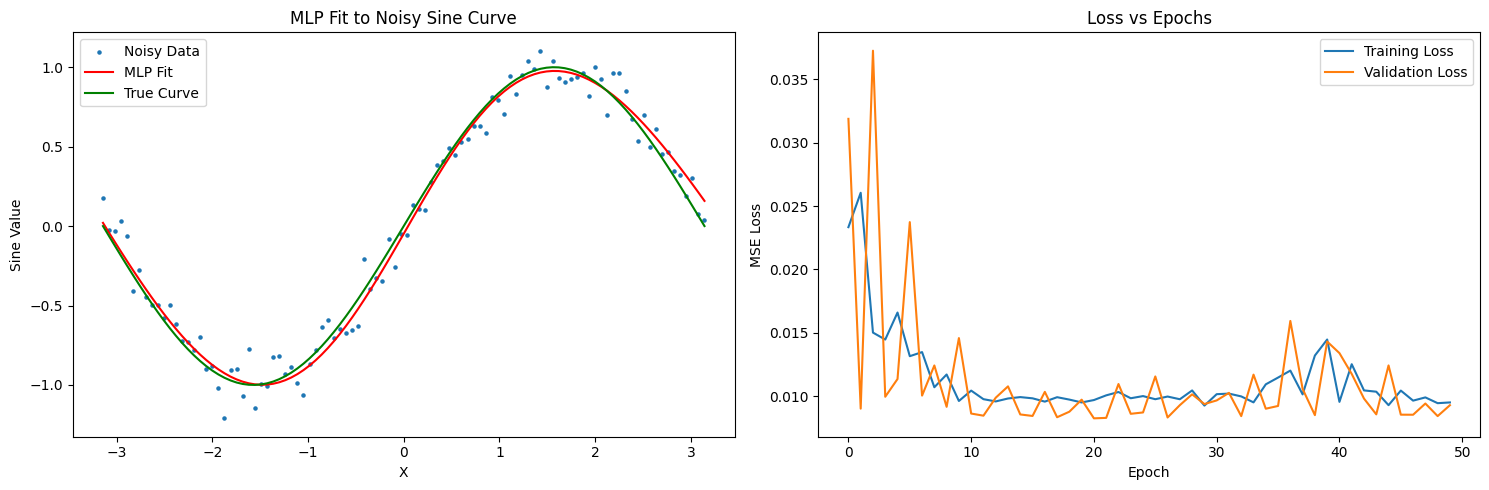

In [25]:
# Predictions
predictions = model.predict(X)

# Plotting the results
plt.figure(figsize=(15, 5))

# Plotting the fit to the noisy sine curve
plt.subplot(1, 2, 1)
plt.scatter(X, Y, s=5, label='Noisy Data')
plt.plot(X, predictions, color='red', label='MLP Fit')
plt.plot(x_values, np.sin(x_values), color='green', label='True Curve')
plt.title('MLP Fit to Noisy Sine Curve')
plt.xlabel('X')
plt.ylabel('Sine Value')
plt.legend()

# Plotting the loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.savefig('Regular_MLP_fit.png', facecolor='white')
plt.show()